# このノートブックについて

コイントスを題材にベイズ推定の練習をする  
なお、表が出る=1とする。

# ライブラリインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd

/Users/morishuuya/.pyenv/versions/anaconda3-2019.03/envs/base2/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/morishuuya/.pyenv/versions/anaconda3-2019.03/envs/base2/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# 関数

In [2]:
# ベータ事後分布からα、βの値を計算する関数
def calc_ab(trace):
    ex = trace["p"].mean()
    varx = trace["p"].var()
    
    alpha = ((ex**2) * ( 1 - ex) * 1 / varx ) - ex
    beta = (alpha / ex) - alpha
    
    return alpha, beta

# 実験１

事前分布：ベータ一様分布  
真の確率：0.1

とてもイカサマコイン

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 5500/5500 [00:02<00:00, 2322.49it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.118832,0.010175,0.000221,0.099785,0.13925


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26f89358>,
      dtype=object)

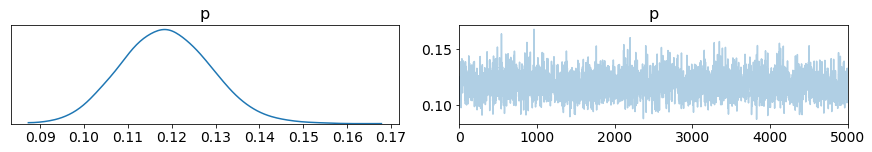

In [111]:
true_p = 0.1
observed = stats.bernoulli.rvs(p = true_p, size = 1000)
n = len(observed)

with pm.Model() as model_1:
    p = pm.Beta("p", alpha = 1, beta = 1)
    obs = pm.Bernoulli("obs",p=p, observed=observed)
    
    trace_1 = pm.sample(5000, chains=1)

display("summary:",pm.summary(trace_1))
pm.traceplot(trace_1)

真の確率0.1に対し、事後分布の平均値が0.11となっているため概ね正しい。

# 実験２
実験１の事後分布を事前分布として用い新たに推定する  

事前分布：実験１の事後分布  
真の確率:0.5

今度はまともなコイン

## 事前分布の計算

In [112]:
alpha , beta = calc_ab(trace_1)
print("alpha:", alpha)
print("beta:", beta)

alpha: 120.06311596685643
beta: 890.2994029720778


## 推定

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 5500/5500 [00:02<00:00, 2375.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.296939,0.010494,0.000208,0.276057,0.317043


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2567eeb8>,
      dtype=object)

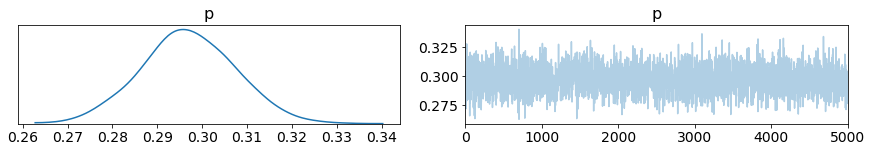

In [114]:
true_p = 0.5
observed = stats.bernoulli.rvs(p = true_p, size = 1000)

with pm.Model() as model_2:
    p = pm.Beta("p", alpha = alpha, beta = beta)
    obs = pm.Bernoulli("obs",p=p, observed=observed)
    
    trace_2 = pm.sample(5000, chains=1)

display("summary:",pm.summary(trace_2))
pm.traceplot(trace_2)

真の確率0.5に対し、 事後分布の平均値0.29だった

事前分布の影響が多大である

# 実験3

途中でイカサマコインにすり替えられた  
すり替えたことを証明するため、前半と後半の分布を確認する  
また、すり替えたタイミングを推定する  

事前分布：ベータ一様分布  
前半の真の確率：0.5  
後半の真の確率:0.1

In [121]:
befor_p = 0.5
after_p = 0.1

befor_observed = stats.bernoulli.rvs(p = befor_p, size = 1000)
after_observed = stats.bernoulli.rvs(p = after_p, size = 1000)

observed = np.concatenate([befor_observed, after_observed])
n = len(observed)

In [123]:
with pm.Model() as model_3:
    count = np.arange(n)
    
    p_1 = pm.Beta("p_1", alpha = 1, beta = 1)
    p_2 = pm.Beta("p_2", alpha = 1, beta = 1)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)
    
    p_mix = pm.math.switch(count < tau, p_1, p_2)
    
    obs = pm.Bernoulli("obs", p = p_mix , observed=observed)
    
    trace_3= pm.sample(1000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p_2, p_1]
>Metropolis: [tau]
100%|██████████| 1500/1500 [00:01<00:00, 1005.80it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


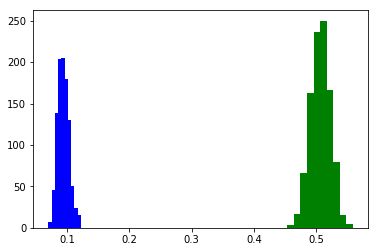

In [130]:
plt.hist(trace_3["p_1"], color="g")
plt.hist(trace_3["p_2"], color="b")
plt.show()

前半部分と後半部分で確率がかなり異なっているため、すり替えたと考えられる

'summary'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
tau,1009.679000,3.720747,0.301945,1002.000000,1016.000000
p_1,0.507090,0.015850,0.000418,0.477599,0.538168
p_2,0.093733,0.009328,0.000275,0.074946,0.110708


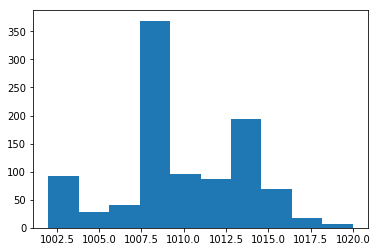

In [133]:
display("summary", pm.summary(trace_3))
plt.hist(trace_3["tau"])
plt.show()

真のタイミングは10000回目、推定値は10009回目で概ね正解である

# 実験4

コイントスを一回ずつ繰り返し、分布の変化を確認する

最初の事前分布をベータ一様分布とする

## 関数

In [153]:
def coin_toss(true_p, count, alpha, beta):
    observed = stats.bernoulli.rvs(p = true_p, size = count)
    n = len(observed)

    with pm.Model() as model_4:
        p = pm.Beta("p", alpha = alpha, beta = beta)
        obs = pm.Bernoulli("obs",p=p, observed=observed)

        trace_4 = pm.sample(1000, chains=1)

    display("summary:",pm.summary(trace_4))
    pm.traceplot(trace_4)
    alpha, beta = calc_ab(trace_4)
    
    return alpha, beta, trace_4

# 推定

In [192]:
true_p = 0.3
alpha = 1
beta = 1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2294.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.49198,0.282289,0.012493,0.012697,0.948005


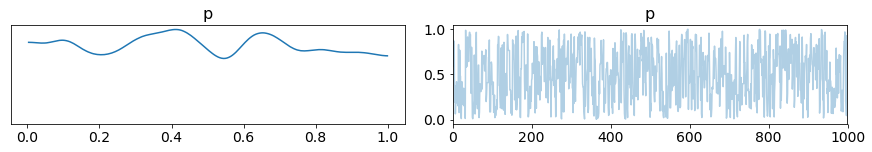

In [193]:
#事前分布
alpha, beta , trace_4= coin_toss(true_p=true_p, count=0, alpha=alpha, beta=beta)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2330.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.668164,0.234681,0.011289,0.194314,0.998726


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2409.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.496716,0.218026,0.010356,0.10797,0.891787


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2378.34it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.39606,0.191511,0.010391,0.072307,0.754165


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2465.73it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.329288,0.173347,0.008483,0.024242,0.648105


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2550.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.280399,0.156569,0.007139,0.031325,0.5863


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2377.48it/s]
The acceptance probability does not match the target. It is 0.9013154016132264, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.237356,0.142908,0.007074,0.017718,0.538423


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2560.06it/s]
The acceptance probability does not match the target. It is 0.8797446198271005, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.204623,0.127924,0.006177,0.015366,0.458269


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2450.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.192477,0.120402,0.005721,0.017742,0.43255


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2473.75it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.27153,0.135214,0.005862,0.038304,0.548133


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [p]
100%|██████████| 1500/1500 [00:00<00:00, 2543.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


'summary:'

,mean,sd,mc_error,hpd_2.5,hpd_97.5
p,0.243564,0.131135,0.006001,0.015226,0.485176


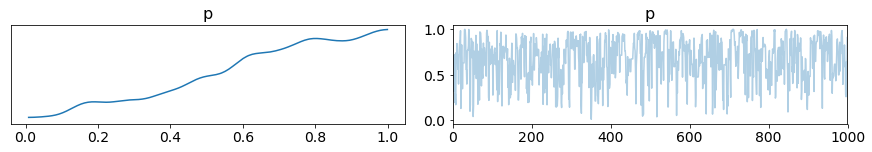

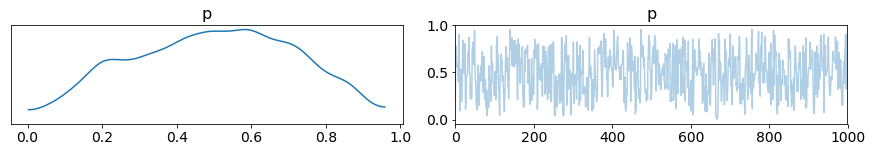

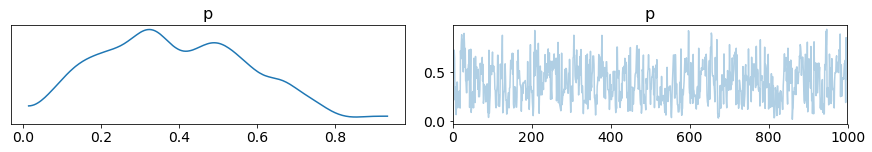

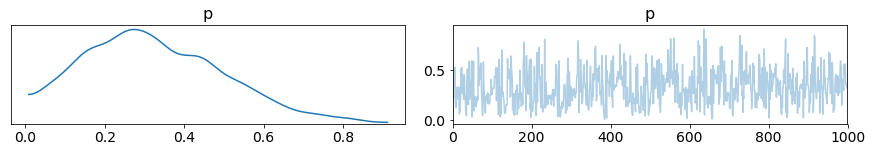

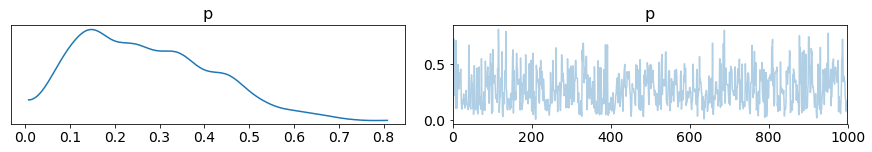

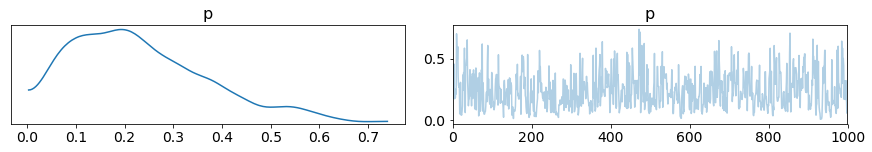

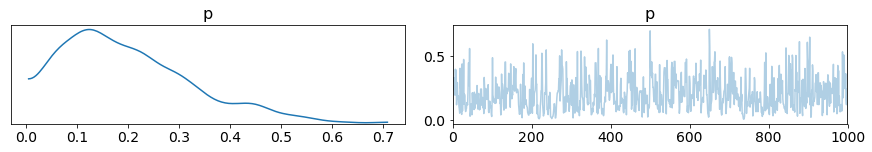

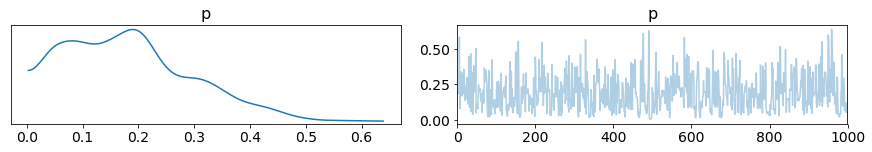

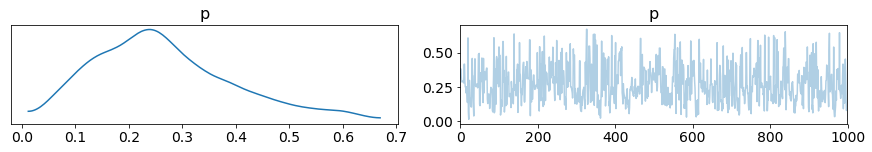

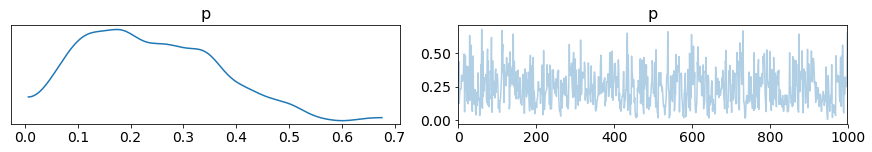

In [196]:
# 10回投げた
history = []
for i in range(10):
    alpha, beta, trace_4 = coin_toss(true_p=true_p, count=1, alpha=alpha, beta=beta)
    if i % 2 == 0:
        history.append(trace_4["p"])
plt.savefig("coint_toss")

## 実験４　まとめ

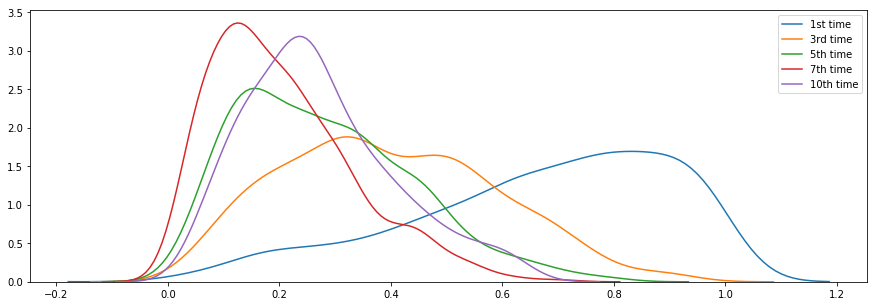

In [200]:
plt.figure(figsize=(15, 5))
sns.kdeplot(history[0], label="1st time")
sns.kdeplot(history[1], label="3rd time")
sns.kdeplot(history[2], label="5th time")
sns.kdeplot(history[3], label="7th time")
sns.kdeplot(history[4], label="th time")



plt.legend()
plt.savefig("coin_toss")
plt.show()
